In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.transforms import v2
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # Implement the forward function in the network
        c1 = F.relu(self.conv1(x))
        # Subsampling layer S2: 2x2 grid, purely functional,
        s2 = self.pool(c1)
        # Convolution layer C3: 6 input channels, 16 output channels,
        c3 = F.leaky_relu(self.conv2(s2))
        s4 = self.pool(c3)
        # Subsampling layer S4: 2x2 grid, purely functional,
        s4 = torch.flatten(s4, 1)
        s5 = F.leaky_relu(self.fc1(s4))
        # outputs a (N, 10) Tensor
        output = self.fc2(s5)
        output = self.sig(output)

        return output

In [4]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):

    train_loss=[]
    val_loss=[] 
    
    for epoch in range(epochs):
        

            # Extract the labels and turn them into one-hot representation (note: not all loss functions needs this)
            for inputs, labels in train_loader:
                labels = labels.view(-1, 1).float()
                #print(f"Input shape: {inputs.shape}")  # Should be (batch_size, 3, height, width)

                # Predict for each digit in the batch what class they belong to
                prediction = model.forward(inputs)
                # Calculate the loss of the prediction by comparing to the expected output
                output = criterion(prediction,labels)
                #print(prediction)
                #print(labels)

                # Backpropagate the loss through the network to find the gradients of all parameters
                output.backward()
                optimizer.step()

                # Clear stored gradient values
                optimizer.zero_grad()
                train_loss.append(output.item())
                
            for inputs, labels in val_loader:
                labels = labels.view(-1, 1).float()
        
                
                # Predict for each digit in the batch what class they belong to
                prediction = model.forward(inputs)

                # Calculate the loss of the prediction by comparing to the expected output
                output = criterion(prediction,labels)
                val_loss.append(output.item())

    epoch = np.arange(len(train_loss))
    plt.figure()
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_loss, 'r', label='Training loss',)
    #plt.plot(epoch, val_loss, 'b', label='Validation loss')
    plt.legend()
    plt.xlabel('Instances'), plt.ylabel('Loss')
    plt.show()

    epoch = np.arange(len(val_loss))
    plt.figure()
    plt.figure(figsize=(10, 6))
    #plt.plot(epoch, train_loss, 'r', label='Training loss',)
    plt.plot(epoch, val_loss, 'b', label='Validation loss')
    plt.legend()
    plt.xlabel('Instances'), plt.ylabel('Loss')
    plt.show()



In [10]:
def test_model(model, criterion, optimizer, test_loader):

    test_loss=[]
    conf_output=[]
    conf_labels=[]
    conf_pred=[]
                        
    for inputs, labels in test_loader:
        labels = labels.view(-1, 1).float()
        #conf_labels.append(labels.item())
        conf_labels.extend(labels.view(-1).tolist())
        # Predict for each digit in the batch what class they belong to
        prediction = torch.argmax(model.forward(inputs))
        conf_pred.append(prediction.item())
        conf_output.append(round(prediction.item()))

        # Calculate the loss of the prediction by comparing to the expected output
        output = criterion(prediction,labels)
        test_loss.append(output.item())
        
    conf_matrix=confusion_matrix(conf_output, conf_labels)
    epoch = np.arange(len(test_loss))
    plt.figure()
    plt.figure(figsize=(10, 6))
    #plt.plot(epoch, train_loss, 'r', label='Training loss',)
    plt.plot(epoch, test_loss, 'b', label='Test loss')
    plt.legend()
    plt.xlabel('Instances'), plt.ylabel('Loss')
    plt.show()
    print(conf_pred)
    print(conf_output)
    print(conf_labels)
    print(conf_matrix)
    acuracy=(conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[1][0]+conf_matrix[0][1]+conf_matrix[0][0]+conf_matrix[1][1])
    print(acuracy)

def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

In [21]:
# Hyperparams. Set these to reasonable values
batch_size = 10
SHUFFLE = True  #?
LEARNING_RATE = 1e-6
epochs = 40

In [11]:
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1,1]
])

# Load the full CIFAR-10 training set
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load the test set separately
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(full_trainset))  # 80% of training data
val_size = len(full_trainset) - train_size  # Remaining 20%
trainset, valset = random_split(full_trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
mean_train, std_train = get_mean_std(trainloader)

valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
mean_val, std_val = get_mean_std(valloader)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


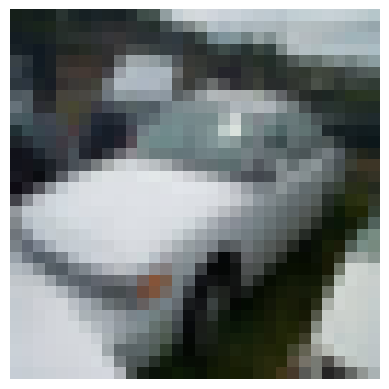

In [17]:
def imshow(img):
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(images[0])

<Figure size 640x480 with 0 Axes>

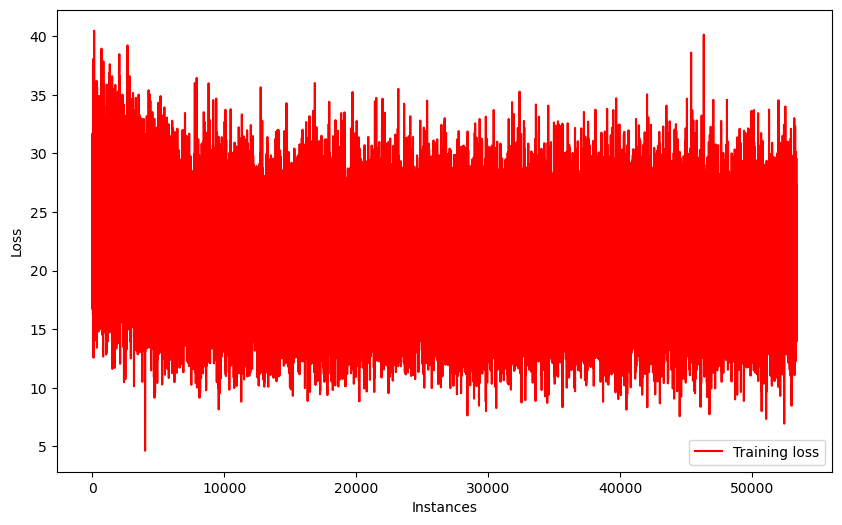

<Figure size 640x480 with 0 Axes>

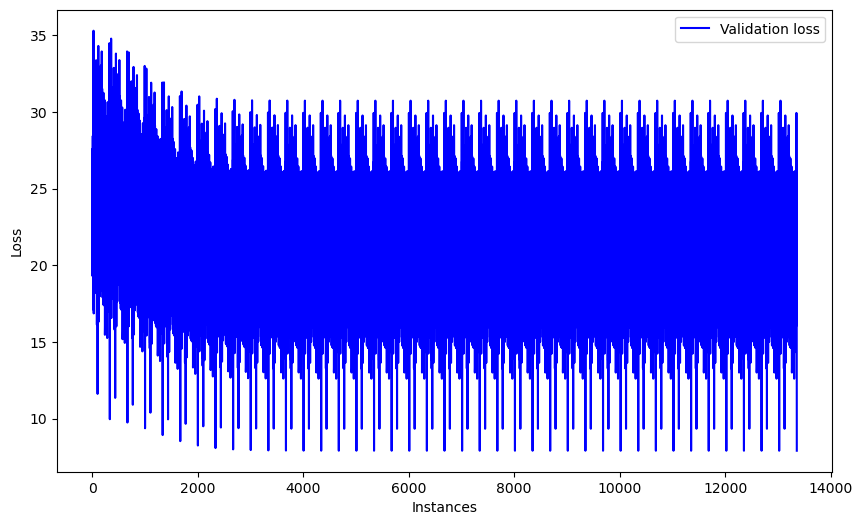

In [22]:
train_transforms = v2.Compose([
    v2.Normalize(mean=[mean_train,mean_train,mean_train],std=[std_train,std_train,std_train]),
    v2.RandomHorizontalFlip(p=0.1),
    v2.RandomVerticalFlip(p=0.1),
    v2.RandomInvert(p=0.1),
    transforms.ToTensor()
    # Add training augmentations here, remember: we do not want to transform the validation images.
])

val_test_transforms = transforms.Compose([
    transforms.ToTensor(),  # Only basic transformation
    v2.Normalize(mean=[mean_val,mean_val,mean_val],std=[std_val,std_val,std_val])
])

#Transform the data whith nomalization and so on
trainloader.dataset.transform= train_transforms
valloader.dataset.transform=val_test_transforms
testloader.dataset.transform=val_test_transforms

# Load our network
model = Net()

# Define our loss function
criterion = nn.MSELoss()

# Define our optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) #Weight decay as regularization

# Train the model
trained_model = train_model(model, criterion, optimizer, trainloader, valloader, epochs)
